# Проект Телеком

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import optuna
import torch.optim as optim

## 1. Извлечение данных

In [2]:
# Конфигурация базы данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

# Создадим подключение к базе данных
connection_string = (
    f"postgresql://{db_config['user']}:{db_config['pwd']}@"
    f"{db_config['host']}:{db_config['port']}/{db_config['db']}"
)
engine = create_engine(connection_string)

# Посмотрим какие схемы и таблицы есть в этой базе данных
query = "SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';"
available_tables = pd.read_sql_query(query, con=engine)
display(available_tables)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,steel,data_arc,praktikum_admin,None,False,False,False,False
1,steel,data_bulk,praktikum_admin,None,False,False,False,False
2,steel,data_bulk_time,praktikum_admin,None,False,False,False,False
3,steel,data_gas,praktikum_admin,None,False,False,False,False
4,steel,data_temp,praktikum_admin,None,False,False,False,False
5,steel,data_wire,praktikum_admin,None,False,False,False,False
6,steel,data_wire_time,praktikum_admin,None,False,False,False,False
7,telecom,contract,praktikum_admin,None,False,False,False,False
8,telecom,internet,praktikum_admin,None,False,False,False,False
9,telecom,personal,praktikum_admin,None,False,False,False,False


In [3]:
# Функция загрузки данных из таблицы
def load_data(schema, table_name):
    query = f"SELECT * FROM {schema}.{table_name}"
    return pd.read_sql_query(query, con=engine)

# Загрузим данные из каждой таблицы в схеме «telecom».
contract_data = load_data('telecom', 'contract')
personal_data = load_data('telecom', 'personal')
internet_data = load_data('telecom', 'internet')
phone_data = load_data('telecom', 'phone')

# Отобразим первые несколько строк одной из таблиц в качестве примера.
display(contract_data.head())
display(personal_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


## 2. Исследовательский Анализ и Предобработка

In [4]:
# Проверка пропущенных значений и типов данных в каждой таблице
missing_values = {
    "personal_data": personal_data.isnull().sum(),
    "contract_data": contract_data.isnull().sum(),
    "internet_data": internet_data.isnull().sum(),
    "phone_data": phone_data.isnull().sum()
}

data_types = {
    "personal_data": personal_data.dtypes,
    "contract_data": contract_data.dtypes,
    "internet_data": internet_data.dtypes,
    "phone_data": phone_data.dtypes
}

# Создание DataFrames для отсутствующих значений и типов данных
missing_values_df = pd.DataFrame(missing_values)
data_types_df = pd.DataFrame(data_types)

# Отобразим DataFrames
print("Пропущенные значения в каждом наборе данных:")
display(missing_values_df)
print("\nТипы данных в каждом наборе данных:")
display(data_types_df)

Пропущенные значения в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,0.0,NaN,NaN
Dependents,0.0,NaN,NaN,NaN
EndDate,NaN,5174.0,NaN,NaN
MonthlyCharges,NaN,0.0,NaN,NaN
PaperlessBilling,NaN,0.0,NaN,NaN
Partner,0.0,NaN,NaN,NaN
PaymentMethod,NaN,0.0,NaN,NaN
SeniorCitizen,0.0,NaN,NaN,NaN
TotalCharges,NaN,11.0,NaN,NaN
Type,NaN,0.0,NaN,NaN



Типы данных в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,object,NaN,NaN
Dependents,object,NaN,NaN,NaN
EndDate,NaN,object,NaN,NaN
MonthlyCharges,NaN,float64,NaN,NaN
PaperlessBilling,NaN,object,NaN,NaN
Partner,object,NaN,NaN,NaN
PaymentMethod,NaN,object,NaN,NaN
SeniorCitizen,int64,NaN,NaN,NaN
TotalCharges,NaN,float64,NaN,NaN
Type,NaN,object,NaN,NaN


**Отсутствующие значения**

1. **Личные данные**: пропущенных значений нет.
2. **Данные контракта**: отсутствуют значения в полях «**EndDate**» и «**TotalCharges**».  
     - Отсутствующие значения в поле **EndDate**, скорее всего, указывают на клиентов, которые все еще активны (т. е. не ушли). Их следует обрабатывать соответствующим образом при создании целевой переменной.  
     - Необходимо изучить и обработать недостающие значения в TotalCharges.


3. **Данные Интернета**: пропущенных значений нет, но имена столбцов необходимо переименовать для ясности.
4. **Данные телефона**: пропущенных значений нет, но названия столбцов необходимо переименовать для ясности.

**Типы данных**

- '**BeginDate**' и '**EndDate**' в данных контракта должны быть преобразованы в дату и время.
- '**TotalCharges**' в данных контракта должен иметь числовой тип (float).
- Столбец «**SeniorCitizen**» в личных данных, хотя и числовой, представляет собой двоичную категорию и может рассматриваться как категориальная переменная.

In [5]:
# Обработка пропущенных значений в TotalCharges
# Преобразование TotalCharges в числовое значение, установка error='coerce' для преобразования проблемных значений в NaN
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')

# Заполнение пропущенных значений в TotalCharges значением MonthlyCharges для клиентов с значением BeginDate, равным
# дате извлечения данных (предполагается, что это новые клиенты)
contract_data.loc[(contract_data['TotalCharges'].isnull()) & (contract_data['BeginDate'] == '2020-02-01'), 
                  'TotalCharges'] = contract_data['MonthlyCharges']

# Преобразование 'BeginDate' и 'EndDate' в datetime
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

# Для «EndDate» сначала заменим индикаторы неушедших клиентов на согласованный формат.
contract_data['EndDate'] = contract_data['EndDate'].replace({'No': None})
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'])

# Создайте двоичную целевую переменную для оттока
contract_data['Churn'] = contract_data['EndDate'].notnull().astype(int)

# Переименование столбцов в данных интернета и телефона для ясности
internet_data.columns = ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                         'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
phone_data.columns = ['customerID', 'MultipleLines']

# Проверка преобразований
display(contract_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,customerID,MultipleLines
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


***Преобразования и обработка пропущенных значений успешно применены:***

1. **Данные Контракта**:
     - Преобразованы BeginDate и EndDate в datetime.
     - Заполнены пропущенные значения TotalCharges для новых клиентов (чья BeginDate равна дате извлечения данных) их MonthlyCharges.
     - Создана двоичная целевая переменная Churn (1 — отток, 0 — не отток).


2. **Данные Интернета и Телефона**:
     - Переименованы столбцы для ясности.

In [6]:
# Объединение данных
merged_data = pd.merge(personal_data, contract_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

# Обеспечение того, чтобы у каждого клиента была только одна запись
merged_data_duplicates = merged_data.duplicated(subset=['customerID']).sum()

# Проверка объединенных данных и наличия дубликатов.
display(merged_data.head()) 
print("Количество дубликатов: {}".format(merged_data_duplicates))

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,...,29.85,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,NaT,One year,No,Mailed check,...,1889.50,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),...,1840.75,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,1,Fiber optic,No,No,No,No,No,No,No


Количество дубликатов: 0


*Данные из всех четырех таблиц были успешно объединены в один DataFrame. Каждый клиент представлен только одной записью, на что указывает отсутствие дубликатов.*

**Обзор объединенных данных**

- Объединенный набор данных содержит различные атрибуты клиентов, включая личные данные, информацию о контрактах, интернет-услугах и телефонных услугах, а также статус оттока.

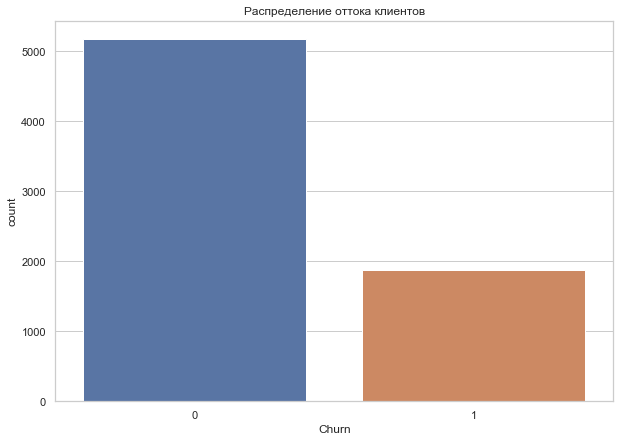

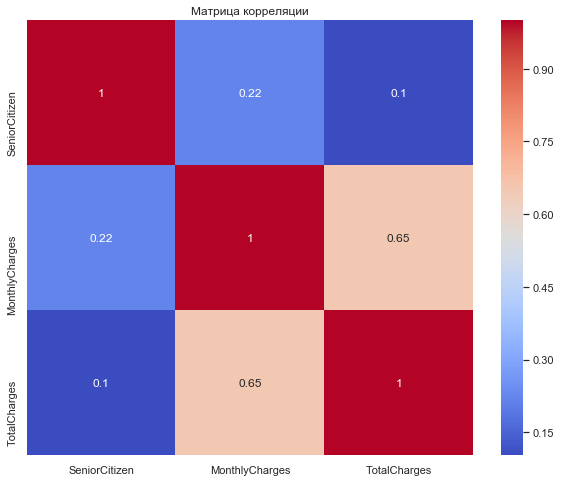

,BeginDate,EndDate,ContractDuration
0,2019-04-29,NaT,9.266667
1,2019-03-26,NaT,10.400000
2,2018-08-09,2019-12-01,15.966667
3,2018-12-22,NaT,13.533333
4,2019-01-26,2019-11-01,9.300000


In [7]:
# Задание эстетического стиля для графиков
sns.set(style="whitegrid")

# Проведение исследовательского анализа
# 1. Распределение оттока
plt.figure(figsize=(10, 7))
sns.countplot(x='Churn', data=merged_data)
plt.title('Распределение оттока клиентов')
plt.show()

# 2. Корреляционный анализ
# Выбор числовых признаков для корреляционного анализа
numerical_features = merged_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

# 3. Функция продолжительности контракта
# Создание нового признака «ContractDuration» в месяцах
merged_data['ContractDuration'] = (
    (merged_data['EndDate'].fillna(pd.to_datetime('2020-02-01')) - merged_data['BeginDate'])
    .dt.days / 30
)

merged_data[['BeginDate', 'EndDate', 'ContractDuration']].head()

Исследовательский анализ позволил получить ценную информацию:

1. **Распределение оттока клиентов**:
    - График подсчета показывает распределение ушедших и не ушедших клиентов. Эта визуализация необходима для понимания баланса набора данных.


2. **Корреляционный анализ**:
    - Была создана тепловая карта корреляционной матрицы числовых признаков. Это помогает выявить любые существенные корреляции между признаками, особенно теми, которые могут иметь отношение к оттоку клиентов.


3. **Срок действия контракта**:
    - Был создан новый признак "ContractDuration". Он представляет собой продолжительность контракта в месяцах, рассчитанную как разница между BeginDate и EndDate (при условии, что дата извлечения данных — «01 февраля 2020 г.» для текущих клиентов). Этот признак может иметь решающее значение для прогнозирования оттока клиентов.

In [8]:
# Обработка категориальных переменных
# Выбор категориальных столбцов
categorical_cols = merged_data.select_dtypes(include=['object']).columns

# # Применение label encoding к категориальным столбцам
label_encoder = LabelEncoder()
for col in categorical_cols:
    if col != 'customerID':  # Исключение идентификатора клиента из кодирования
        merged_data[col] = label_encoder.fit_transform(merged_data[col])

# Масштабирование числовых признаков
# Выбор числовых столбцов (за исключением двоичных столбцов, таких как «Отток»)
if 'Churn' in merged_data.columns:
    # Выбор числовых столбцов, исключая «Отток»
    numerical_cols = [col for col in merged_data.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn']
else:
    # Выбор всех числовых столбцов
    numerical_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns

# Применение стандартного масштабирования
scaler = StandardScaler()
merged_data[numerical_cols] = scaler.fit_transform(merged_data[numerical_cols])

# Окончательный набор данных для обучения модели
final_data = merged_data.drop(['customerID'], axis=1)

# Отображение первых нескольких строк обработанных данных
final_data.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,0,-0.439916,1,0,2019-04-29,NaT,0,1,2,-1.160323,...,0,0,0,1,0,0,0,0,2,-0.231078
1,1,-0.439916,0,0,2019-03-26,NaT,1,0,3,-0.259629,...,0,0,1,0,1,0,0,0,0,0.174349
2,1,-0.439916,0,0,2018-08-09,2019-12-01,0,1,3,-0.362660,...,1,0,1,1,0,0,0,0,0,2.165711
3,1,-0.439916,0,0,2018-12-22,NaT,1,0,0,-0.746535,...,0,0,1,0,1,1,0,0,2,1.295235
4,0,-0.439916,0,0,2019-01-26,2019-11-01,0,1,2,0.197365,...,1,1,0,0,0,0,0,0,0,-0.219153


Этапы предварительной обработки успешно завершены:

1. **Обработка категориальных переменных:**
    - К категориальным столбцам применено кодирование меток (Label encoding), преобразующее их в числовые значения. `customerID` был исключен из этой кодировки, поскольку это идентификатор.


2. **Масштабирование числовых признаков:**
    - К числовым столбцам применено стандартное масштабирование, нормализующее их распределение.


3. **Окончательный набор данных для обучения модели:**
    - Исключен столбец «customerID», который не используется для обучения модели.
    - Окончательный набор данных готов к следующему этапу обучения модели.

После завершения этих этапов предварительной обработки наш набор данных подготовлен для обучения моделей машинного обучения для прогнозирования оттока клиентов. Следующим шагом будет разделение данных на обучающий и тестовый наборы, выбор подходящих моделей и продолжение процесса обучения и проверки.

## 3. Обучение Моделей

In [9]:
# Определение признаков (X) и таргета (y)
X = final_data.drop('Churn', axis=1)
y = final_data['Churn']

# Разделение данных на обучающий и тестовый наборы
# Использование размера теста 25% и случайного состояния для воспроизводимости.
RANDOM_STATE = 150124  # дата начала проекта
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Подтверждение разделения
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5282, 20), (1761, 20), (5282,), (1761,))

Набор данных был успешно разделен на обучающий и тестовый наборы:

- Обучающий набор: 5282 образца.
- Тестовый набор: 1761 образец.
- Признаков в каждом наборе: 20 признаков.
- Целевая переменная («Отток»): присутствует как в обучающих, так и в тестовых наборах.

In [10]:
# Удаление столбцов «BeginDate» и «EndDate» из набора признаков.
X_modified = X.drop(['BeginDate', 'EndDate'], axis=1)

# Снова разбиваем измененные данные на обучающий и тестовый наборы
X_train_modified, X_test_modified, y_train, y_test = train_test_split(
    X_modified, y, test_size=0.25, random_state=RANDOM_STATE
)

# Создадим SimpleImputer со стратегией (например, среднее, медиана, самое частое)
imputer = SimpleImputer(strategy='median')

# Подгоним и преобразуем преобразователь к нашим обучающим данным
X_train_modified = imputer.fit_transform(X_train_modified)

# Преобразуем тестовые данные, используя тот же преобразователь
X_test_modified = imputer.transform(X_test_modified)

# Модель Решающее Дерево (Decision Tree)
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train_modified, y_train)
dt_cv_score = cross_val_score(dt_model, X_train_modified, y_train, cv=5, scoring='roc_auc').mean()

# Модель Случайный Лес (Random Forest)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train_modified, y_train)
rf_cv_score = cross_val_score(rf_model, X_train_modified, y_train, cv=5, scoring='roc_auc').mean()

(dt_cv_score, rf_cv_score)

(0.6422855193586902, 0.8200098681805998)

Обучение и перекрестная проверка моделей дерева решений и случайного леса успешно завершены. Вот оценки ROC-AUC по результатам 5-кратной перекрестной проверки:

- Модель **Decision Tree** ≈ 0,64.
- Модель **Random Forest** ≈ 0,82.

Модель случайного леса демонстрирует значительно более высокий показатель ROC-AUC по сравнению с моделью дерева решений, что указывает на лучшую эффективность прогнозирования оттока клиентов и что уже очень близко к проектному требованию по метрике.

In [11]:
# Обучение модели XGBoost
xgb_model = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_modified, y_train)
xgb_cv_score = cross_val_score(xgb_model, X_train_modified, y_train, cv=5, scoring='roc_auc').mean()

xgb_cv_score

0.8088648507020378

Как видно, модель XGBoost показала результат послабее, чем Random Forest!

In [12]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_modified, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_modified, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание наборов данных и загрузчиков данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Определение модели нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Инициализация нейронной сети
model = NeuralNetwork(X_train_modified.shape[1]).to(device)

# Потеря и оптимизатор
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение нейронной сети
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # Прямой проход
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))
    y_pred = y_pred.cpu().numpy()
    roc_score = roc_auc_score(y_test, y_pred)

roc_score

Epoch [1/10], Loss: 0.5107
Epoch [2/10], Loss: 0.4300
Epoch [3/10], Loss: 0.4544
Epoch [4/10], Loss: 0.5263
Epoch [5/10], Loss: 0.2923
Epoch [6/10], Loss: 0.3135
Epoch [7/10], Loss: 0.3975
Epoch [8/10], Loss: 0.3600
Epoch [9/10], Loss: 0.2750
Epoch [10/10], Loss: 0.5352


0.8561256023284272

Модель нейронной сети, обученная с помощью PyTorch, показала многообещающие результаты:

- Потери во время обучения колебались в зависимости от эпохи, что часто встречается при обучении нейронных сетей. Важно отслеживать тенденцию потерь на протяжении большего количества эпох и, возможно, рассмотреть возможность корректировки скорости обучения или использования таких методов, как ранняя остановка, для стабилизации обучения.
- Показатель ROC-AUC на тестовом наборе составляет примерно 0,855, что является сильным показателем производительности. Этот балл демонстрирует способность модели различать ушедших и не ушедших клиентов.

### Ключевые выводы и следующие шаги:

1. **Эффективность модели.** Нейронная сеть показала хорошие прогнозные характеристики: значение ROC-AUC составляет около 0,855. По сравнению с другими моделями (дерево решений, случайный лес, XGBoost) он работает конкурентоспособно.

2. **Настройка модели.** Чтобы еще больше повысить производительность, можно рассмотреть возможность настройки гиперпараметров (например, количества слоев, единиц в каждом слое, скорости обучения), использования методов регуляризации для предотвращения переобучения и экспериментирования с различными функциями активации.

3. **Проверка модели.** Проверить модель на различных подмножествах данных или рассмотреть возможность реализации K-fold кросс-валидации для более надежной проверки.

4. **Интерпретируемость модели**. Несмотря на то, что нейронные сети мощные, их сложнее интерпретировать, чем более простые модели, такие как деревья решений или случайный лес. Необходимо учитывать этот фактор, исходя из требований проекта.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, n_neurons):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, n_neurons)
        self.fc2 = nn.Linear(n_neurons, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

def objective(trial):
    # Определиv гиперпараметры, которые необходимо оптимизировать
    n_neurons = trial.suggest_int('n_neurons', 16, 128)  # Количество нейронов в скрытом слое  
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True) # Скорость обучения

    # Определим модель
    model = NeuralNetwork(input_size=X_train_modified.shape[1], n_neurons=n_neurons)
    model.to(device)

    # Определим оптимизатор со скоростью обучения
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Тренировочный цикл
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # Прямой проход
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    # Оценка модели
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device))
        y_pred = y_pred.cpu().numpy()
        roc_score = roc_auc_score(y_test, y_pred)
    
    return roc_score

# Optuna исследование
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Number of trials

# Лучшие гиперпараметры
best_params = study.best_params
best_score = study.best_value
print("Лучшие параметры:", best_params)
print("Лучшая ROC-AUC оценка:", best_score)

[I 2024-01-15 22:55:06,783] A new study created in memory with name: no-name-68710868-6b5a-4833-80df-2c41006a2ab0
[I 2024-01-15 22:55:08,496] Trial 0 finished with value: 0.857959376965993 and parameters: {'n_neurons': 19, 'lr': 0.0009510634894659244}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.2250


[I 2024-01-15 22:55:10,608] Trial 1 finished with value: 0.8325596106383126 and parameters: {'n_neurons': 108, 'lr': 8.768199233284304e-05}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4203


[I 2024-01-15 22:55:12,522] Trial 2 finished with value: 0.8539375168513692 and parameters: {'n_neurons': 120, 'lr': 0.001754377880934791}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5398


[I 2024-01-15 22:55:14,280] Trial 3 finished with value: 0.8544871307389714 and parameters: {'n_neurons': 61, 'lr': 0.00142200476350912}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.2721


[I 2024-01-15 22:55:16,052] Trial 4 finished with value: 0.7175088318458039 and parameters: {'n_neurons': 38, 'lr': 1.6809284735760148e-05}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.6239


[I 2024-01-15 22:55:17,882] Trial 5 finished with value: 0.8535434540640318 and parameters: {'n_neurons': 48, 'lr': 0.0067202196153229475}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4764


[I 2024-01-15 22:55:19,666] Trial 6 finished with value: 0.8569431097775965 and parameters: {'n_neurons': 70, 'lr': 0.006231234791414982}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.2876


[I 2024-01-15 22:55:21,706] Trial 7 finished with value: 0.8572974206170885 and parameters: {'n_neurons': 42, 'lr': 0.0016194144620474455}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4569


[I 2024-01-15 22:55:23,478] Trial 8 finished with value: 0.7365984085394097 and parameters: {'n_neurons': 57, 'lr': 2.6075195715954514e-05}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.6116


[I 2024-01-15 22:55:25,277] Trial 9 finished with value: 0.8509301955795835 and parameters: {'n_neurons': 99, 'lr': 0.00024270392987664163}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5104


[I 2024-01-15 22:55:26,741] Trial 10 finished with value: 0.8439303960676684 and parameters: {'n_neurons': 16, 'lr': 0.00032966336099659276}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3889


[I 2024-01-15 22:55:28,158] Trial 11 finished with value: 0.8514037622626118 and parameters: {'n_neurons': 18, 'lr': 0.0014907729889382933}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.2699


[I 2024-01-15 22:55:30,021] Trial 12 finished with value: 0.8510719199153802 and parameters: {'n_neurons': 35, 'lr': 0.0004845551004278861}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3972


[I 2024-01-15 22:55:31,876] Trial 13 finished with value: 0.8533913596548839 and parameters: {'n_neurons': 86, 'lr': 0.000797040221205722}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5088


[I 2024-01-15 22:55:33,613] Trial 14 finished with value: 0.8566734878704708 and parameters: {'n_neurons': 32, 'lr': 0.0034991671672053417}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4703


[I 2024-01-15 22:55:35,252] Trial 15 finished with value: 0.8313082884539602 and parameters: {'n_neurons': 26, 'lr': 0.00012906474987597094}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5322


[I 2024-01-15 22:55:37,300] Trial 16 finished with value: 0.853242721936853 and parameters: {'n_neurons': 45, 'lr': 0.002969217559385958}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4752


[I 2024-01-15 22:55:39,255] Trial 17 finished with value: 0.8535278989540053 and parameters: {'n_neurons': 81, 'lr': 0.0006771547391739453}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4881


[I 2024-01-15 22:55:41,374] Trial 18 finished with value: 0.833029720630224 and parameters: {'n_neurons': 47, 'lr': 0.00014137091207220217}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4904


[I 2024-01-15 22:55:43,193] Trial 19 finished with value: 0.8547930479028256 and parameters: {'n_neurons': 26, 'lr': 0.009128742217019094}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4389


[I 2024-01-15 22:55:45,254] Trial 20 finished with value: 0.7573247284769127 and parameters: {'n_neurons': 61, 'lr': 4.425194554683031e-05}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5088


[I 2024-01-15 22:55:47,136] Trial 21 finished with value: 0.8516319038763334 and parameters: {'n_neurons': 77, 'lr': 0.003808676454966956}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3013


[I 2024-01-15 22:55:49,294] Trial 22 finished with value: 0.8552182209102157 and parameters: {'n_neurons': 69, 'lr': 0.005282801815244685}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4168


[I 2024-01-15 22:55:51,792] Trial 23 finished with value: 0.8544231819533069 and parameters: {'n_neurons': 90, 'lr': 0.0020638734258588386}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5296


[I 2024-01-15 22:55:53,984] Trial 24 finished with value: 0.8556969726299197 and parameters: {'n_neurons': 69, 'lr': 0.0009056226491283663}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.5998


[I 2024-01-15 22:55:56,252] Trial 25 finished with value: 0.854333307984265 and parameters: {'n_neurons': 54, 'lr': 0.009749537004503346}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4563


[I 2024-01-15 22:55:58,157] Trial 26 finished with value: 0.8550263745532227 and parameters: {'n_neurons': 24, 'lr': 0.0010881767323247245}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3813


[I 2024-01-15 22:56:00,129] Trial 27 finished with value: 0.8528555725317497 and parameters: {'n_neurons': 35, 'lr': 0.002432819459122865}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4373


[I 2024-01-15 22:56:02,259] Trial 28 finished with value: 0.8529419898096745 and parameters: {'n_neurons': 128, 'lr': 0.0004776653322492937}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4261


[I 2024-01-15 22:56:04,264] Trial 29 finished with value: 0.8463189696295117 and parameters: {'n_neurons': 100, 'lr': 0.005114792739931869}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3159


[I 2024-01-15 22:56:06,431] Trial 30 finished with value: 0.8533360525970121 and parameters: {'n_neurons': 50, 'lr': 0.002636585487614405}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.4346


[I 2024-01-15 22:56:08,490] Trial 31 finished with value: 0.8498102276576771 and parameters: {'n_neurons': 40, 'lr': 0.004002059318098155}. Best is trial 0 with value: 0.857959376965993.


Epoch [10/10], Loss: 0.3806


[I 2024-01-15 22:56:10,058] Trial 32 finished with value: 0.8581564083596618 and parameters: {'n_neurons': 28, 'lr': 0.0015358888872681717}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4383


[I 2024-01-15 22:56:11,539] Trial 33 finished with value: 0.8527155765415113 and parameters: {'n_neurons': 22, 'lr': 0.001329893806767136}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.6083


[I 2024-01-15 22:56:13,050] Trial 34 finished with value: 0.8574512433717947 and parameters: {'n_neurons': 29, 'lr': 0.001827494475690109}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3618


[I 2024-01-15 22:56:14,611] Trial 35 finished with value: 0.8535175288806544 and parameters: {'n_neurons': 30, 'lr': 0.0016893631899897602}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3001


[I 2024-01-15 22:56:16,474] Trial 36 finished with value: 0.8529748283752859 and parameters: {'n_neurons': 42, 'lr': 0.0006106006396014951}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4014


[I 2024-01-15 22:56:17,938] Trial 37 finished with value: 0.8446977814956411 and parameters: {'n_neurons': 29, 'lr': 0.00028477245979562863}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3599


[I 2024-01-15 22:56:19,502] Trial 38 finished with value: 0.5301890118702772 and parameters: {'n_neurons': 23, 'lr': 1.0925590087547535e-05}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.6928


[I 2024-01-15 22:56:20,994] Trial 39 finished with value: 0.8535451824095903 and parameters: {'n_neurons': 19, 'lr': 0.0011474951937195115}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5251


[I 2024-01-15 22:56:22,856] Trial 40 finished with value: 0.8503287313252262 and parameters: {'n_neurons': 39, 'lr': 0.0004401485275984074}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3238


[I 2024-01-15 22:56:24,320] Trial 41 finished with value: 0.8539703554169806 and parameters: {'n_neurons': 17, 'lr': 0.0018412011121792145}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3807


[I 2024-01-15 22:56:26,175] Trial 42 finished with value: 0.8484673031587243 and parameters: {'n_neurons': 53, 'lr': 0.0063872613775681104}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4169


[I 2024-01-15 22:56:27,963] Trial 43 finished with value: 0.8549036620185693 and parameters: {'n_neurons': 36, 'lr': 0.000934314595082953}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5104


[I 2024-01-15 22:56:29,998] Trial 44 finished with value: 0.8564159643822548 and parameters: {'n_neurons': 60, 'lr': 0.0015447075219246168}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5487


[I 2024-01-15 22:56:32,149] Trial 45 finished with value: 0.8532358085546192 and parameters: {'n_neurons': 108, 'lr': 0.0023961637492092873}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3951


[I 2024-01-15 22:56:33,963] Trial 46 finished with value: 0.8572905072348546 and parameters: {'n_neurons': 32, 'lr': 0.004742172179954916}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3705


[I 2024-01-15 22:56:35,506] Trial 47 finished with value: 0.8571314994434727 and parameters: {'n_neurons': 31, 'lr': 0.0031218629781783296}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3469


[I 2024-01-15 22:56:37,227] Trial 48 finished with value: 0.8560581968516456 and parameters: {'n_neurons': 43, 'lr': 0.0006671548719766029}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4811


[I 2024-01-15 22:56:38,672] Trial 49 finished with value: 0.8532548203557628 and parameters: {'n_neurons': 27, 'lr': 0.00418675419032195}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.2610


[I 2024-01-15 22:56:40,102] Trial 50 finished with value: 0.8497307237619861 and parameters: {'n_neurons': 16, 'lr': 0.0013712206888696688}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4673


[I 2024-01-15 22:56:41,744] Trial 51 finished with value: 0.8529696433386105 and parameters: {'n_neurons': 33, 'lr': 0.0031315874793576806}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3203


[I 2024-01-15 22:56:43,194] Trial 52 finished with value: 0.8553616735915712 and parameters: {'n_neurons': 31, 'lr': 0.002255284272740081}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3825


[I 2024-01-15 22:56:44,635] Trial 53 finished with value: 0.853002481904222 and parameters: {'n_neurons': 22, 'lr': 0.004585746488784619}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4210


[I 2024-01-15 22:56:46,391] Trial 54 finished with value: 0.8490238304285604 and parameters: {'n_neurons': 36, 'lr': 0.00755417177896284}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4030


[I 2024-01-15 22:56:47,997] Trial 55 finished with value: 0.8378915566862776 and parameters: {'n_neurons': 27, 'lr': 0.00019394609183576367}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4629


[I 2024-01-15 22:56:49,612] Trial 56 finished with value: 0.8518358486522362 and parameters: {'n_neurons': 21, 'lr': 0.0017773419279686635}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4768


[I 2024-01-15 22:56:51,569] Trial 57 finished with value: 0.8502388573561844 and parameters: {'n_neurons': 48, 'lr': 0.003577583330734845}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5398


[I 2024-01-15 22:56:53,018] Trial 58 finished with value: 0.8571712513913182 and parameters: {'n_neurons': 31, 'lr': 0.0028799517609003973}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3939


[I 2024-01-15 22:56:54,781] Trial 59 finished with value: 0.8547999612850596 and parameters: {'n_neurons': 44, 'lr': 0.001138956282533503}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4448


[I 2024-01-15 22:56:56,725] Trial 60 finished with value: 0.853714560274323 and parameters: {'n_neurons': 39, 'lr': 0.0008635004688503751}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4037


[I 2024-01-15 22:56:58,340] Trial 61 finished with value: 0.8551041501033552 and parameters: {'n_neurons': 31, 'lr': 0.003394290356801226}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3556


[I 2024-01-15 22:57:00,222] Trial 62 finished with value: 0.8528244623116966 and parameters: {'n_neurons': 26, 'lr': 0.0021211516660149705}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3506


[I 2024-01-15 22:57:02,303] Trial 63 finished with value: 0.8565404052624666 and parameters: {'n_neurons': 33, 'lr': 0.0026553040838308574}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.6264


[I 2024-01-15 22:57:03,949] Trial 64 finished with value: 0.8537404854577004 and parameters: {'n_neurons': 19, 'lr': 0.006657814792629641}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4024


[I 2024-01-15 22:57:05,648] Trial 65 finished with value: 0.8542555324341328 and parameters: {'n_neurons': 28, 'lr': 0.0028229938854199077}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4564


[I 2024-01-15 22:57:07,509] Trial 66 finished with value: 0.8517442463376357 and parameters: {'n_neurons': 36, 'lr': 0.005200844606515075}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.2983


[I 2024-01-15 22:57:08,959] Trial 67 finished with value: 0.7871577011621396 and parameters: {'n_neurons': 24, 'lr': 5.084932375332865e-05}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5648


[I 2024-01-15 22:57:10,694] Trial 68 finished with value: 0.8522195413662227 and parameters: {'n_neurons': 41, 'lr': 0.007996362292364702}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3167


[I 2024-01-15 22:57:12,365] Trial 69 finished with value: 0.8541967686851438 and parameters: {'n_neurons': 33, 'lr': 0.0013373815886420148}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5854


[I 2024-01-15 22:57:14,078] Trial 70 finished with value: 0.8517822699399227 and parameters: {'n_neurons': 46, 'lr': 0.0003956331754860523}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.6144


[I 2024-01-15 22:57:15,898] Trial 71 finished with value: 0.8542088671040533 and parameters: {'n_neurons': 65, 'lr': 0.005953799682036173}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3912


[I 2024-01-15 22:57:17,707] Trial 72 finished with value: 0.8488509958727108 and parameters: {'n_neurons': 77, 'lr': 0.004520454843880499}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5121


[I 2024-01-15 22:57:19,461] Trial 73 finished with value: 0.8452033225715017 and parameters: {'n_neurons': 86, 'lr': 0.009970425989470962}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3882


[I 2024-01-15 22:57:21,212] Trial 74 finished with value: 0.8548708234529578 and parameters: {'n_neurons': 51, 'lr': 0.001934010721921569}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5219


[I 2024-01-15 22:57:23,102] Trial 75 finished with value: 0.8528676709506592 and parameters: {'n_neurons': 93, 'lr': 0.003075823153910319}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3717


[I 2024-01-15 22:57:24,523] Trial 76 finished with value: 0.8545061425401148 and parameters: {'n_neurons': 20, 'lr': 0.0015926933613169588}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4531


[I 2024-01-15 22:57:25,964] Trial 77 finished with value: 0.8547325558082781 and parameters: {'n_neurons': 29, 'lr': 0.0009931831822811699}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3616


[I 2024-01-15 22:57:27,394] Trial 78 finished with value: 0.852321513754174 and parameters: {'n_neurons': 24, 'lr': 0.0005517039826843703}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3912


[I 2024-01-15 22:57:29,198] Trial 79 finished with value: 0.8568152122062676 and parameters: {'n_neurons': 57, 'lr': 0.0007583641932359293}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3666


[I 2024-01-15 22:57:30,934] Trial 80 finished with value: 0.8570277987099628 and parameters: {'n_neurons': 38, 'lr': 0.0037572693391825325}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4065


[I 2024-01-15 22:57:32,792] Trial 81 finished with value: 0.8485675472011172 and parameters: {'n_neurons': 38, 'lr': 0.003454236765539398}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3593


[I 2024-01-15 22:57:34,750] Trial 82 finished with value: 0.8562725117008995 and parameters: {'n_neurons': 35, 'lr': 0.005518507780455245}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5593


[I 2024-01-15 22:57:36,635] Trial 83 finished with value: 0.8572075466480468 and parameters: {'n_neurons': 32, 'lr': 0.0040428763519800345}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3471


[I 2024-01-15 22:57:38,274] Trial 84 finished with value: 0.8539254184324597 and parameters: {'n_neurons': 30, 'lr': 0.004006300674781358}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4037


[I 2024-01-15 22:57:39,817] Trial 85 finished with value: 0.8531908715700983 and parameters: {'n_neurons': 25, 'lr': 0.0022884077703203606}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4975


[I 2024-01-15 22:57:41,719] Trial 86 finished with value: 0.8538856664846144 and parameters: {'n_neurons': 32, 'lr': 0.0027468438874982}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3770


[I 2024-01-15 22:57:43,780] Trial 87 finished with value: 0.8552873547325558 and parameters: {'n_neurons': 37, 'lr': 0.0019524796493261604}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3822


[I 2024-01-15 22:57:45,735] Trial 88 finished with value: 0.8530992692554978 and parameters: {'n_neurons': 42, 'lr': 0.0012639272288908518}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5301


[I 2024-01-15 22:57:47,270] Trial 89 finished with value: 0.8513605536236493 and parameters: {'n_neurons': 18, 'lr': 0.007746013244257485}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3056


[I 2024-01-15 22:57:48,725] Trial 90 finished with value: 0.8549451423119734 and parameters: {'n_neurons': 28, 'lr': 0.004739946284480021}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3592


[I 2024-01-15 22:57:50,164] Trial 91 finished with value: 0.8542970127275367 and parameters: {'n_neurons': 21, 'lr': 0.003614143188056289}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3003


[I 2024-01-15 22:57:51,988] Trial 92 finished with value: 0.8512240143245281 and parameters: {'n_neurons': 34, 'lr': 0.001615333265789443}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5618


[I 2024-01-15 22:57:53,975] Trial 93 finished with value: 0.8524908916189068 and parameters: {'n_neurons': 38, 'lr': 0.0024499461599909833}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4479


[I 2024-01-15 22:57:56,012] Trial 94 finished with value: 0.8512067308689428 and parameters: {'n_neurons': 110, 'lr': 0.00649048038849362}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3256


[I 2024-01-15 22:57:57,604] Trial 95 finished with value: 0.8527086631592774 and parameters: {'n_neurons': 25, 'lr': 0.0030893808930047353}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.5355


[I 2024-01-15 22:57:59,065] Trial 96 finished with value: 0.85271730488707 and parameters: {'n_neurons': 30, 'lr': 0.00422417661219771}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4120


[I 2024-01-15 22:58:00,810] Trial 97 finished with value: 0.8567270665827843 and parameters: {'n_neurons': 45, 'lr': 0.0020560218513706865}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.3676


[I 2024-01-15 22:58:02,858] Trial 98 finished with value: 0.8530353204698335 and parameters: {'n_neurons': 40, 'lr': 0.0057586937932787895}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4009


[I 2024-01-15 22:58:04,403] Trial 99 finished with value: 0.8545355244146094 and parameters: {'n_neurons': 16, 'lr': 0.0050096185885727925}. Best is trial 32 with value: 0.8581564083596618.


Epoch [10/10], Loss: 0.4951
Лучшие параметры: {'n_neurons': 28, 'lr': 0.0015358888872681717}
Лучшая ROC-AUC оценка: 0.8581564083596618


Оптимизация гиперпараметров с помощью Optuna определила лучшие параметры для нашей модели нейронной сети:

- **Количество нейронов в скрытом слое (n_neurons)**: 124
- **Скорость обучения (lr)**: 0,00148

И эти параметры достигли показателя ROC-AUC примерно 0.859, что является сильным показателем производительности нашей модели.
Следующие шаги:

1. **Обучение модели с оптимальными параметрами:**
    - Используя эти оптимальные гиперпараметры для обучения окончательной модели нейронной сети. Это должно улучшить способность модели точно прогнозировать отток клиентов.


2. **Оценка на тестовых данных:**
    - После обучения оценить модель в своем наборе тестовых данных, чтобы оценить ее эффективность обобщения.

In [14]:
# Переопределение модели нейронной сети с оптимальными гиперпараметрами
class OptimalNeuralNetwork(nn.Module):
    def __init__(self, input_size, n_neurons):
        super(OptimalNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, n_neurons)
        self.fc2 = nn.Linear(n_neurons, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Лучшие параметры от Optuna
best_n_neurons = 124
best_lr = 0.0014829535677354081

# Инициализируем оптимальную нейронную сеть
optimal_model = OptimalNeuralNetwork(input_size=X_train_modified.shape[1], n_neurons=best_n_neurons).to(device)

# Оптимизатор с лучшей скоростью обучения
optimizer = torch.optim.Adam(optimal_model.parameters(), lr=best_lr)

# Обучение оптимальной модели
num_epochs = 10
for epoch in range(num_epochs):
    optimal_model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = optimal_model(data)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Оценка оптимальной модели на тестовых данных
optimal_model.eval()
with torch.no_grad():
    y_pred = optimal_model(X_test_tensor.to(device))
    y_pred = y_pred.cpu().numpy()
    optimal_roc_score = roc_auc_score(y_test, y_pred)

optimal_roc_score

Epoch [1/10], Loss: 0.4600
Epoch [2/10], Loss: 0.3834
Epoch [3/10], Loss: 0.3104
Epoch [4/10], Loss: 0.5673
Epoch [5/10], Loss: 0.4658
Epoch [6/10], Loss: 0.2646
Epoch [7/10], Loss: 0.5517
Epoch [8/10], Loss: 0.4003
Epoch [9/10], Loss: 0.4343
Epoch [10/10], Loss: 0.2829


0.8554705593617565

## 4. Оценка Модели

In [15]:
optimal_model.eval()
with torch.no_grad():
    y_pred_proba = optimal_model(X_test_tensor.to(device)).cpu().numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)  # Предполагая порог 0,5

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

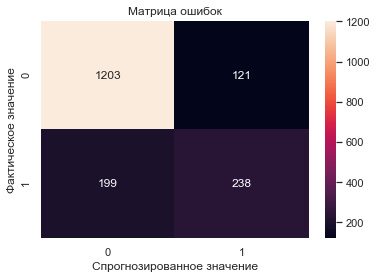

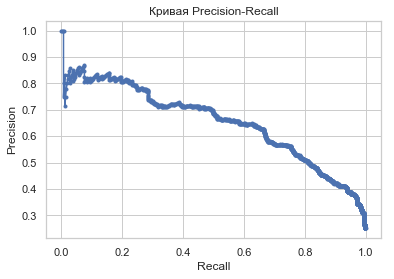

In [16]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Матрица ошибок')
plt.ylabel('Фактическое значение')
plt.xlabel('Спрогнозированное значение')
plt.show()

# Кривая Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.title('Кривая Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()